In [ ]:
# Downloading tslearn library for time series clustering
pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 8.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn import decomposition
from sklearn.model_selection import train_test_split
import os
from tqdm.auto import tqdm
from sklearn import decomposition
import shutil
from itertools import groupby
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
import matplotlib.pyplot as plt

## Parameters

In [ ]:
# path of original data folder
data_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data"
csvD_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/csv_files"
demographics = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/demographics.csv"
dem_df = pd.read_csv(demographics)

## Reading the dataset

`total_right_features` contains the aggregated (total-sum) forces from the 8 sensors underneath the right foot.

`total_left_features` contains the aggregated (total-sum) forces from the 8 sensors underneath the left foot.

`y_df` contains : 
1. `ID` id of the patient, 
2. `y` equal to 1 if the individual has PD, and 0 if the individual is from control group
3. `level` is the level of PD (0, 2, 2.5, 3) zero is for control group. The levels are changed later to (0,2,3,4) to transform `float` into `int` values.


In [ ]:
total_right_features=[None]*306       #306 is the numbe of walks we have
total_left_features=[None]*306        #306 is the numbe of walks we have
y_df = pd.DataFrame(columns=['ID', 'y', 'level'])
for i,name in enumerate(os.listdir(csvD_path)):
  id = name.split('_')[0]
  level = dem_df['HoehnYahr'][dem_df['ID'] == id ].values[0]
  if 'Co' in name:  
    parkinson = 0
  elif 'Pt' in name:
    parkinson = 1
  y_df = y_df.append({'ID': id, 'y': parkinson, 'level': level}, ignore_index=True)
  total_right_features[i] = pd.read_csv(csvD_path+'/' + name).iloc[:, 18].values 
  total_left_features[i] = pd.read_csv(csvD_path+'/' + name).iloc[:, 17].values

## Preprocess the dataset

### Forces Values

- Usually, Vertical Ground React Force VGRF values less than 20N are generated from noise
- For gait cycle segmentation, to eliminate the effect of gait initiation and termenation, the first and last 20 seconds of VGRF data was discarded.

In [ ]:
# preprocessing total right values
for i, vector in enumerate(total_right_features):
  total_right_features[i] = vector[20:-20]
  vector[vector < 20] = 0

In [ ]:
# preprocessing total left values
for i, vector in enumerate(total_left_features):
  total_left_features[i] = vector[20:-20]
  vector[vector < 20] = 0

### Demographics

- null values are assigned for PD level for control group so we replace it with 0
- class labels are 0,2,2.5,3 Converting them to : 0,2,3,4 

In [ ]:
y_df['level'].fillna(0, inplace = True)
y_df['level'].replace(3, 4, inplace= True)
y_df['level'].replace(2.5, 3, inplace= True)
y=y_df['level'].astype('int')
y_binary = y_df['y'].astype('int')

##  Gait Cycle Segmentation (stance phases segmentation)
If we consider the right foot for example, A Gait cycle (a step) consists of a Stance phase (where the right foot is on the ground) and a seing Phase(where the right foot is not on the ground while the left foot is on the ground).
The two phases are shown on the following figure of the VGRF from the total sensors for one foot.



In the follwoing we segment the stance phases from each 2 min walk for each individual (healthy control and individuals with different levles od PD.).

I consider two features to segment stance phases from, the sum of forces from all the sensors for the right foot, and the sum of forces from all the sensors for the left foot.


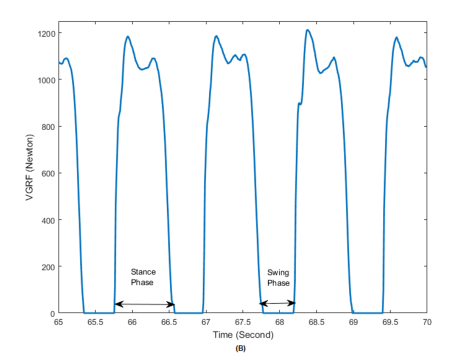

In [ ]:
# Getting stance phases
data = []
stances_level = []
for ind, right_force, left_force in zip(y_df.index, total_right_features , total_left_features):
  right_stances = [list(g) for k, g in groupby(right_force, lambda x:x>0) ]
  right_stances = [l for l in right_stances if any(l)]

  left_stances = [list(g) for k, g in groupby(left_force, lambda x:x>0) ]
  left_stances = [l for l in left_stances if any(l)]

  for stance in right_stances:
    stances_level.append(([y_df["ID"][ind], y_df["y"][ind], y_df["level"][ind], (stance)]))
  for stance in left_stances:
    stances_level.append(([y_df["ID"][ind], y_df["y"][ind], y_df["level"][ind], (stance) ]))

  data.append([y_df["ID"][ind], y_df["y"][ind], y_df["level"][ind], right_stances, left_stances])

`data_df` contains : 
1. `ID` id of an individual, 
2. `y` equal to 1 if the individual has PD, and 0 if the individual is from control group
3. `level` is the level of PD (0, 2,3,4) zero is for control group. 
4. `right_stances` is a list of all stance phases extracted from 2 mins walk for the specific individual. The stance phases are extracted from the sum forces from all sensors underneath the right foot.
5. `left_stances` is a list of all stance phases extracted from 2 mins walk for the specific individual. The stance phases are extracted from the sum of forces from all sensors underneath the left foot.

**save the stances for each individual**

In [ ]:
# saving the data into dataframe
data_df = pd.DataFrame(data, columns =["ID", "y", "level", "rigth_stances", "left_stances"])

In [ ]:
data_df.head()

,ID,y,level,rigth_stances,left_stances
0,GaPt03,1,4.0,"[[23.1, 41.69, 71.17, 138.82, 195.69, 230.78, ...","[[660.44, 641.96, 633.49, 610.61, 598.18, 584...."
1,SiPt02,1,3.0,"[[452.32, 389.51, 326.59, 258.94, 190.52, 143....","[[654.06, 668.91, 676.83, 684.64, 692.67, 700...."
2,SiPt04,1,2.0,"[[772.2, 777.81, 778.36, 781.33, 781.77, 779.7...","[[34.1, 22.88], [23.76, 29.92, 40.04, 122.76, ..."
3,GaPt04,1,3.0,"[[740.74, 733.15, 726.66, 717.86, 708.95, 697....","[[24.75, 45.1, 78.1, 152.68, 233.09, 292.16, 3..."
4,SiPt05,1,3.0,"[[536.8, 537.02, 535.15, 537.02, 532.73, 537.0...","[[576.73, 576.73, 576.73, 576.73, 579.04, 579...."


In [ ]:
# saving the data into file
data_df.to_csv(data_path + '/data_stances.csv', index =False)

`stances_level_df` contains : 
1. `ID` id of an individual, 
2. `y` equal to 1 if the individual has PD, and 0 if the individual is from control group
3. `level` is the level of PD (0, 2,3, 4) zero is for control group. 
4. `stance` is an individual stance phase.
So each 2 min walk is sepleted into stance phases and each stance phase is represented with one row with the information about the individual.


**save each stance with the related level**

In [ ]:
stances_level_df = pd.DataFrame(stances_level, columns =["ID", "y", "level", "stances"])

In [ ]:
stances_level_df.head()

,ID,y,level,stances
0,GaPt03,1,4.0,"[23.1, 41.69, 71.17, 138.82, 195.69, 230.78, 2..."
1,GaPt03,1,4.0,"[34.76, 61.27, 113.19, 165.22, 218.02, 260.26,..."
2,GaPt03,1,4.0,"[25.41, 39.38, 55.55, 89.98, 125.95, 168.63, 2..."
3,GaPt03,1,4.0,"[27.72, 46.31, 74.58, 135.85, 189.09, 226.93, ..."
4,GaPt03,1,4.0,"[32.45, 55.55, 113.3, 180.95, 243.87, 285.01, ..."


In [ ]:
stances_level_df.shape

(63229, 4)

In [ ]:
# saving the data into file
stances_level_df.to_csv(data_path + '/data_individual_stances.csv', index =False)

## Clustering
Clustering time series with dtw algorithm for measuring the distance among the time serieses

## Trying with small amount of data

## Shuffling the data and taking 100 rows

In [ ]:
X_train, X_test, y_train, y_test = train_test_split((stances_level_df['stances']).to_list(), (stances_level_df["level"]).to_list(), test_size=0.33, random_state=42, shuffle = True)

In [ ]:
# transforming into dataset convinent for the library
X = to_time_series_dataset(X_train)

In [ ]:
# the clustering algorithm
km = TimeSeriesKMeans(n_clusters=4, metric="dtw")
# fitting and predicting for 100 stance phase
labels = km.fit_predict(X[:100])

In [ ]:
# getting the ids of the individuals belong to the same group (actual group PD level) 
actual ={ 0:[], 2:[], 3:[], 4:[]}
for i, v in enumerate(y_train[:100]):
    actual[v].append(i)
# getting the ids of the individuals belong to the same group (predicted cluster) 
predicted={0:[], 1:[], 2:[], 3:[]}
for i, v in enumerate(labels):
    predicted[v].append(i)

### Visualizing

#### Visualizing the 4 clusters

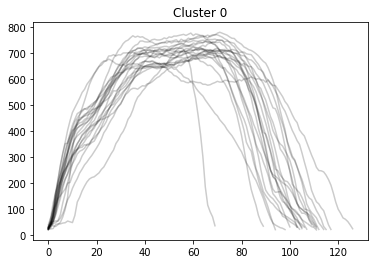

In [ ]:
for label in predicted[0]:
  plt.plot(X[label].ravel(), "k-", alpha=.2)
  #plt.plot(km.cluster_centers_[0].ravel(), "r-")
  plt.title("Cluster 0")

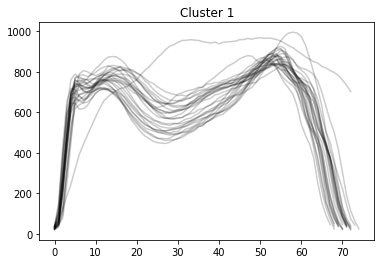

In [ ]:
for label in predicted[1]:
  plt.plot(X[label].ravel(), "k-", alpha=.2)
  #plt.plot(km.cluster_centers_[0].ravel(), "r-")
  plt.title("Cluster 1")

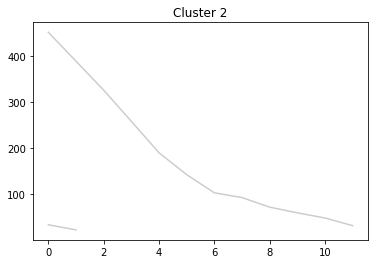

In [ ]:
for label in predicted[2]:
  plt.plot(X[label].ravel(), "k-", alpha=.2)
  #plt.plot(km.cluster_centers_[0].ravel(), "r-")
  plt.title("Cluster 2")

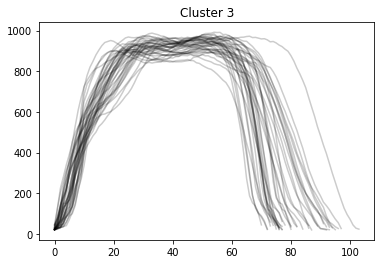

In [ ]:
for label in predicted[3]:
  plt.plot(X[label].ravel(), "k-", alpha=.2)
  #plt.plot(km.cluster_centers_[0].ravel(), "r-")
  plt.title("Cluster 3")

#### Visualizing the actual four labels for the same dataset
The actual labels indicate the different level of Parkinson's disease.

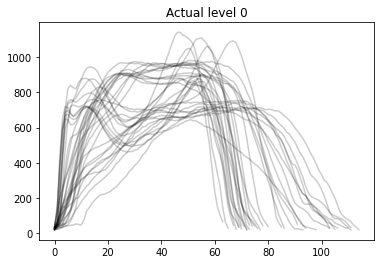

In [ ]:
for ind in actual[0]:
  plt.plot(X[ind].ravel(), "k-", alpha=.2)
  #plt.plot(km.cluster_centers_[0].ravel(), "r-")
  plt.title("Actual level 0")

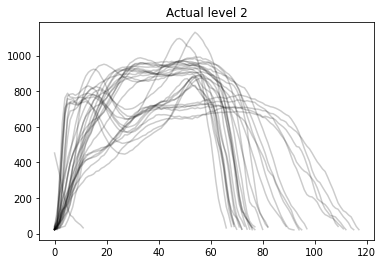

In [ ]:
for ind in actual[2]:
  plt.plot(X[ind].ravel(), "k-", alpha=.2)
  #plt.plot(km.cluster_centers_[0].ravel(), "r-")
  plt.title("Actual level 2")

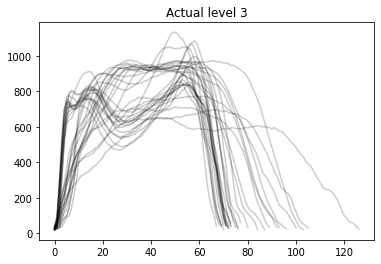

In [ ]:
for ind in actual[3]:
  plt.plot(X[ind].ravel(), "k-", alpha=.2)
  #plt.plot(km.cluster_centers_[0].ravel(), "r-")
  plt.title("Actual level 3")

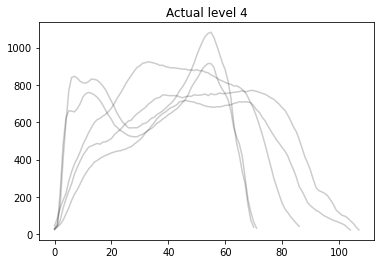

In [ ]:
for ind in actual[4]:
  plt.plot(X[ind].ravel(), "k-", alpha=.2)
  #plt.plot(km.cluster_centers_[0].ravel(), "r-")
  plt.title("Actual level 4")

A notebook with some extra cells (https://colab.research.google.com/drive/1B3iEoKB7A3ifikKxkhQIK4RG5QnGQw9B?usp=sharing)
